In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV



In [30]:
class ASP(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=1.0, rho=0.5, a=3.0, max_iter=100, tol=1e-4):
        self.alpha = alpha
        self.rho = rho
        self.a = a
        self.max_iter = max_iter
        self.tol = tol
        self.coef_ = None
        self.intercept_ = 0.0
    
    def _mcp_derivative(self, beta):
        lambda1 = self.alpha * self.rho
        deriv = np.zeros_like(beta)
        abs_beta = np.abs(beta)
        idx = abs_beta <= self.a * lambda1
        deriv[idx] = -lambda1 * np.sign(beta[idx]) * (1 - abs_beta[idx] / (self.a * lambda1))
        return deriv

    def fit(self, X, y):
        X_mean = np.mean(X, axis=0)
        y_mean = np.mean(y)
        X_centered = X - X_mean
        y_centered = y - y_mean
        
        n, p = X.shape
        beta = np.zeros(p)
        XtX_n = X_centered.T @ X_centered / n
        Xty_n = X_centered.T @ y_centered / n
        
        for _ in range(self.max_iter):
            beta_old = beta.copy()
            mcp_grad = self._mcp_derivative(beta)
            
            for j in range(p):
                if XtX_n[j, j] < 1e-10:
                    continue
                l_j = np.dot(XtX_n[j, :], beta) - XtX_n[j, j] * beta[j] - Xty_n[j] + mcp_grad[j]
                beta[j] = -np.sign(l_j) * max(0, abs(l_j) - self.alpha * (1 - self.rho)) / XtX_n[j, j]
            
            if np.linalg.norm(beta - beta_old) < self.tol:
                break
        
        self.coef_ = beta
        self.intercept_ = y_mean - np.dot(X_mean, beta)
        return self

    def predict(self, X):
        return X @ self.coef_ + self.intercept_

    def score(self, X, y):
        return r2_score(y, self.predict(X))


In [32]:
dataset=pd.read_csv('./titanic.csv')
dataset.columns


Index(['Passengerid', 'Age', 'Fare', 'Sex', 'sibsp', 'Parch', 'Pclass',
       'Embarked', '2urvived'],
      dtype='object')

In [14]:
dataset.shape

(1307, 9)

In [37]:
dataset.isna().sum()

Passengerid    0
Age            0
Fare           0
Sex            0
sibsp          0
Parch          0
Pclass         0
Embarked       2
2urvived       0
dtype: int64

In [38]:
# Drop NA values of Price, since it's our predictive variable we won't impute it
dataset.dropna(inplace=True)

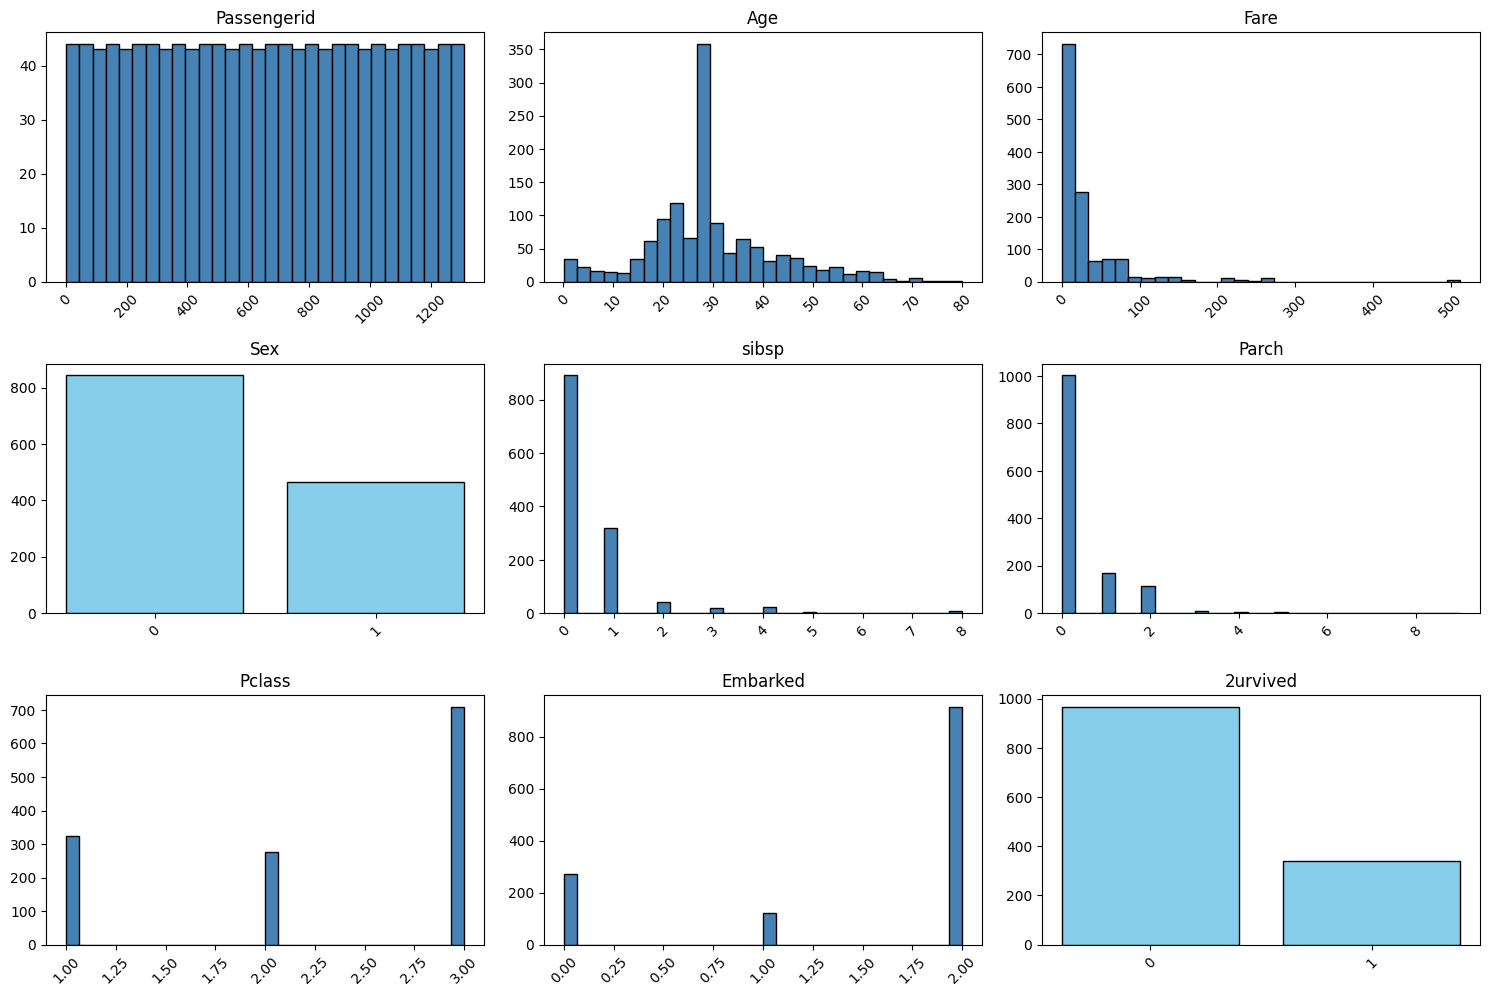

In [33]:
df=dataset
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols = 3
num_rows = (len(numeric_cols) + num_cols - 1) // num_cols  # Ceiling division

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    unique_vals = df[col].dropna().unique()
    
    if set(unique_vals).issubset({0, 1}):
        counts = df[col].value_counts().sort_index()
        axes[i].bar(counts.index.astype(str), counts.values, color='skyblue', edgecolor='black')
        axes[i].set_xticks([0, 1])
        axes[i].set_xticklabels(['0', '1'])
    else:
        axes[i].hist(df[col], bins=30, color='steelblue', edgecolor='black')

    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [15]:
describ1=dataset.describe()
print(describ1)

       Passengerid          Age         Fare          Sex        sibsp  \
count  1307.000000  1307.000000  1307.000000  1307.000000  1307.000000   
mean    655.319816    29.471821    33.209595     0.355011     0.499617   
std     377.922205    12.881592    51.748768     0.478700     1.042273   
min       1.000000     0.170000     0.000000     0.000000     0.000000   
25%     328.500000    22.000000     7.895800     0.000000     0.000000   
50%     655.000000    28.000000    14.454200     0.000000     0.000000   
75%     982.500000    35.000000    31.275000     1.000000     1.000000   
max    1309.000000    80.000000   512.329200     1.000000     8.000000   

             Parch       Pclass     Embarked     2urvived  
count  1307.000000  1307.000000  1307.000000  1307.000000  
mean      0.385616     2.296863     1.492731     0.260138  
std       0.866092     0.836942     0.814626     0.438877  
min       0.000000     1.000000     0.000000     0.000000  
25%       0.000000     2.000000  

In [35]:
def RealDataModelling():
    # Load and prepare data
    # california = fetch_california_housing()
    # X, y = california.data, california.target
    # feature_names = california.feature_names
    X = dataset.drop('2urvived', axis=1)
    y = dataset['2urvived']
    feature_names = dataset.columns
    # # Train-test split and scaling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define models to compare
    models = {
        'LASSO': Lasso(),
        'MCP (ρ=0.9)': ASP(rho=0.9),  # MCP approximation
        'ASP (ρ=0.1)': ASP(rho=0.1),
        'ASP (ρ=0.3)': ASP(rho=0.3),
        'ASP (ρ=0.5)': ASP(rho=0.5),
        'ASP (ρ=0.7)': ASP(rho=0.7),
        'ASP (ρ=0.9)': ASP(rho=0.9)
    }

    # Parameter grids for tuning
    param_grids = {
        'LASSO': {'alpha': np.logspace(-3, 1, 20)},
        'MCP (ρ=0.9)': {'alpha': np.logspace(-3, 1, 20), 'a': [2.5, 3.0, 3.5]},
        'ASP (ρ=0.1)': {'alpha': np.logspace(-3, 1, 20), 'a': [2.5, 3.0, 3.5]},
        'ASP (ρ=0.3)': {'alpha': np.logspace(-3, 1, 20), 'a': [2.5, 3.0, 3.5]},
        'ASP (ρ=0.5)': {'alpha': np.logspace(-3, 1, 20), 'a': [2.5, 3.0, 3.5]},
        'ASP (ρ=0.7)': {'alpha': np.logspace(-3, 1, 20), 'a': [2.5, 3.0, 3.5]},
        'ASP (ρ=0.9)': {'alpha': np.logspace(-3, 1, 20), 'a': [2.5, 3.0, 3.5]}
    }

    # Results storage
    results = []

# Train and evaluate each model
    for name in models:
        print(f"\nTraining {name}...")
        start_time = time.time()
        gs = GridSearchCV(models[name], param_grids[name], cv=5, scoring='neg_mean_squared_error')
        gs.fit(X_train_scaled, y_train)
        
        end_time = time.time()
        training_time = end_time - start_time
        best = gs.best_estimator_
        y_pred = best.predict(X_test_scaled)
        
        results.append({
            'Model': name,
            'Best Params': gs.best_params_,
            'MSE': mean_squared_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred),
            'Features Selected': np.sum(np.abs(best.coef_) > 1e-8),
            'Coefficients': best.coef_,
            'Training': training_time
        })

    # Display results
    print("\nModel Comparison Results:")
    print("{:<12} {:<25} {:<10} {:<10} {:<15} {:<45}".format(
        'Model', 'Best Parameters', 'MSE', 'R2', 'Features', 'TrainingTime (sec)'))
    
    for res in results:
        params_str = ', '.join([f"{k}={v:.3f}" for k, v in res['Best Params'].items()])
        print("{:<12} {:<25} {:<10.4f} {:<10.4f} {:<15}{:<45}".format(
            res['Model'], params_str, res['MSE'], res['R2'], res['Features Selected'], res['Training']))

    # Plot coefficients
    plt.figure(figsize=(15, 8))
    for i, res in enumerate(results, 1):
        plt.subplot(2, 4, i)
        plt.stem(res['Coefficients'], linefmt='-', markerfmt='o', basefmt=' ')
        plt.title(f"{res['Model']}\nMSE: {res['MSE']:.4f}, R2: {res['R2']:.4f}")
        plt.xticks(range(len(feature_names)), feature_names, rotation=45)
        plt.ylim(-1, 1)
    plt.tight_layout()
    plt.show()


Training LASSO...

Training MCP (ρ=0.9)...

Training ASP (ρ=0.1)...

Training ASP (ρ=0.3)...

Training ASP (ρ=0.5)...

Training ASP (ρ=0.7)...

Training ASP (ρ=0.9)...

Model Comparison Results:
Model        Best Parameters           MSE        R2         Features        TrainingTime (sec)                           
LASSO        alpha=0.004               0.1333     0.3593     7              0.0994119644165039                           
MCP (ρ=0.9)  a=2.500, alpha=0.002      0.1329     0.3610     8              0.23373913764953613                          
ASP (ρ=0.1)  a=2.500, alpha=0.004      0.1332     0.3596     7              0.19584107398986816                          
ASP (ρ=0.3)  a=2.500, alpha=0.004      0.1331     0.3600     7              0.21310186386108398                          
ASP (ρ=0.5)  a=2.500, alpha=0.004      0.1331     0.3604     7              0.2164919376373291                           
ASP (ρ=0.7)  a=2.500, alpha=0.004      0.1330     0.3607     8         

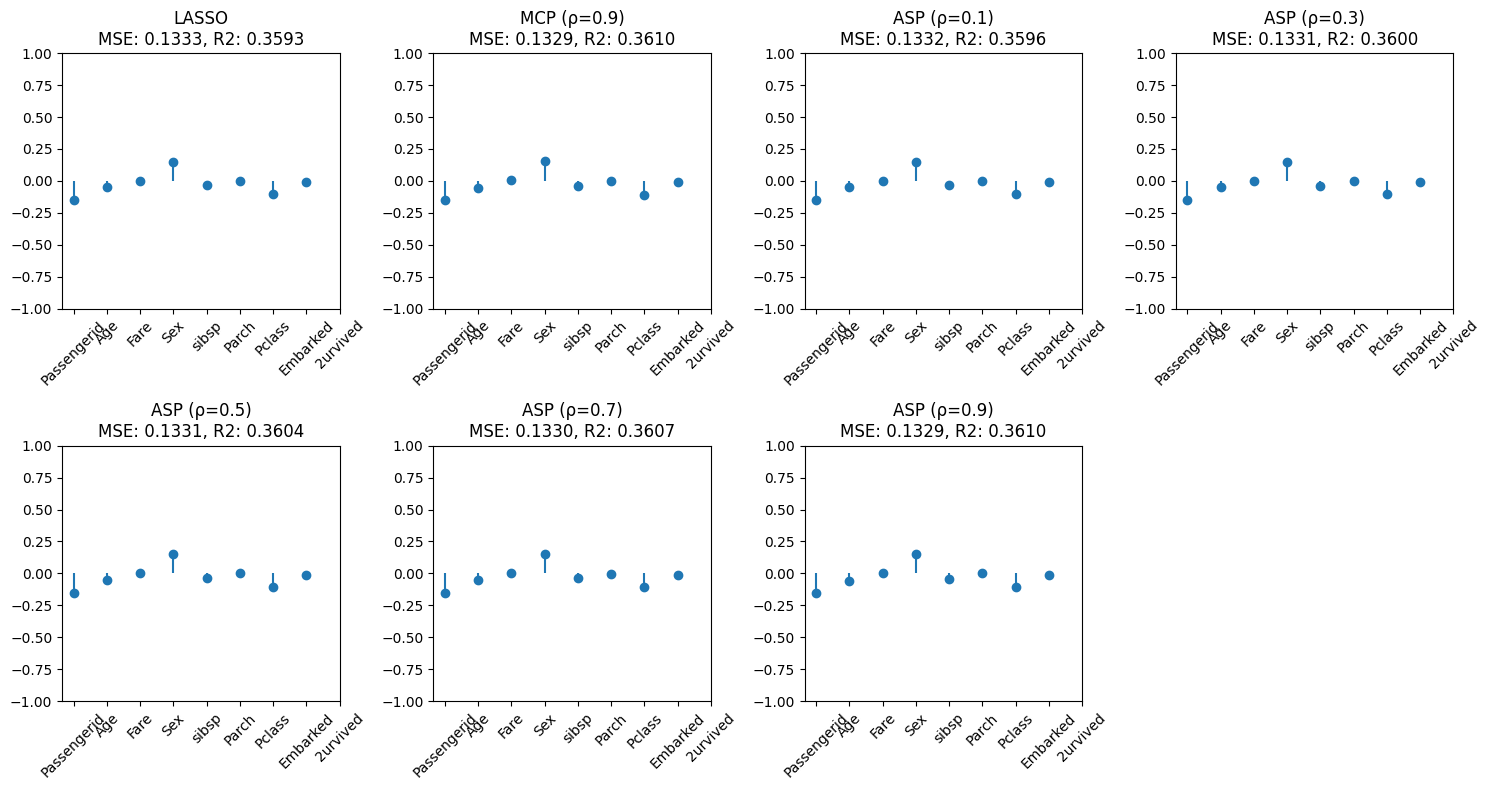

In [39]:
# Run the ML models with model evaluations
RealDataModelling()